In [76]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.linear_model import LinearRegression
from typing import Dict, Optional, Tuple

In [22]:
"""
Import data
"""
raw_data = pd.read_pickle("data.pkl")
raw_data[0:5]

,subject,exp,phasename,num_rep,num_trial,num_formed,num_uttered,prompt,in_or_out,date_run,time_run,block,pitches
0,20,PU,5,44,1,2637,70,HECK,O,20170127,11,3,0 134.355450 1 134.360625 2 134...
1,20,PU,5,36,1,2629,62,HECK,O,20170127,11,3,0 130.217779 1 130.179978 2 130...
2,20,PU,7,20,1,2713,146,HECK,I,20170127,11,3,0 132.486939 1 132.479573 2 132...
3,20,PU,6,6,1,2649,82,HECK,O,20170127,11,3,0 139.037150 1 139.055242 2 139...
4,20,PU,7,8,1,2701,134,HECK,I,20170127,11,3,0 130.927041 1 130.913059 2 130...


In [23]:
"""
Preprocessing
"""

# Create new data frame

# Remove "O" data
df = raw_data[raw_data.in_or_out == "O"]

# Remove first block
df = df[df.block != 1]

# Rename "phasename" to "phasenum"
df.rename(columns = {"phasename": "phasenum", "exp": "condition"}, inplace = True)

# Reset pd indexes
df.reset_index()

# Preview
df[0:5]

,subject,condition,phasenum,num_rep,num_trial,num_formed,num_uttered,prompt,in_or_out,date_run,time_run,block,pitches
0,20,PU,5,44,1,2637,70,HECK,O,20170127,11,3,0 134.355450 1 134.360625 2 134...
1,20,PU,5,36,1,2629,62,HECK,O,20170127,11,3,0 130.217779 1 130.179978 2 130...
3,20,PU,6,6,1,2649,82,HECK,O,20170127,11,3,0 139.037150 1 139.055242 2 139...
5,20,PU,1,1,1,2568,1,HECK,O,20170127,11,3,0 112.625662 1 112.649338 2 112...
7,20,PU,5,39,1,2632,65,HECK,O,20170127,11,3,0 139.263470 1 139.266789 2 139...


In [24]:
"""
Generate summary statistics for each trial
"""

agg: Dict[int, float] = {
    "count": [],
    "avg": [],
    "std": [],
    "minimum": [],
    "med": [],
    "maximum": [],
}
    
for pitches in df.pitches:
    (
        count,
        avg,
        std,
        minimum,
        _,
        med,
        _,
        maximum,
                ) = pitches.describe()
    agg["count"].append(count)
    agg["avg"].append(avg)
    agg["std"].append(std)
    agg["minimum"].append(minimum)
    agg["med"].append(med)
    agg["maximum"].append(maximum)
    
# Preview summary statistics
summary_stats = pd.DataFrame(agg)
summary_stats[0:5]

,count,avg,std,minimum,med,maximum
0,491.0,133.610873,1.544445,124.930762,133.915850,134.887327
1,531.0,128.870786,1.549235,124.541467,129.371750,132.296456
2,461.0,137.901782,0.786993,135.052405,137.730314,140.124944
3,141.0,115.535289,2.270588,112.625662,114.953949,121.897112
4,451.0,134.375365,2.289648,127.755729,133.575767,139.429389


In [25]:
"""
Relativize to F0 of start phase
"""

subjects = df.subject.unique()
conditions = df.condition.unique()

# Subset only start phase trials with the prompt "HECK"
selection = ((df.phasenum == 4) & (df.prompt == "HECK")).to_numpy()
trial_f0 = summary_stats.avg[selection]
trial_subject = df.subject[selection] 
trial_condition = df.condition[selection] 

# Get the baseline F0 for each subject
f0s = {}
for subject in subjects:
    for condition in conditions:
        selection = ((subject == trial_subject) & (condition == trial_condition)).to_numpy()
        trials = trial_f0[selection]
        f0 = trials.mean()
        f0s[(subject, condition)] = f0

# Subtract pitches from baseline F0 
corrected_pitches = []

# For each trial
for i, trial_pitches in enumerate(df.pitches):
        
    # Get the subject's f0
    subject = df.subject.to_numpy()[i]
    condition = df.condition.to_numpy()[i]
    f0 = f0s[(subject, condition)]
    
    # Subtract f0 from values
    trial_corrected_pitches = trial_pitches - f0
    
    # Take mean
    trial_corrected_pitches = trial_corrected_pitches.mean()
    
    # Save in new arrage
    corrected_pitches.append(trial_corrected_pitches)
    
cleaned_df = df.drop(columns = ['pitches', 'num_trial', 'in_or_out'])
cleaned_df['corrected_pitches'] = corrected_pitches

In [28]:
print(cleaned_df)

       subject condition  phasenum  num_rep  num_formed  num_uttered prompt  \
0           20        PU         5       44        2637           70   HECK   
1           20        PU         5       36        2629           62   HECK   
3           20        PU         6        6        2649           82   HECK   
5           20        PU         1        1        2568            1   HECK   
7           20        PU         5       39        2632           65   HECK   
...        ...       ...       ...      ...         ...          ...    ...   
43780       32       FAE         4       16         777           22   HECK   
43783       32       FAE         6       29         860          105   HECK   
43784       32       FAE         6       30         861          106   HECK   
43785       32       FAE         5        9         790           35   HECK   
43787       32       FAE         4       11         772           17   HECK   

       date_run time_run  block  corrected_pitches 

In [30]:
"""
Helper functions
"""

phasenames = {
    "2": "pract2",
    "3": "unk",
    "4": "start",
    "5": "ramp_up",
    "6": "stay",
    "7": "ramp_down",
    }

def subset_data(
    df: pd.DataFrame,
    *,
    condition: Optional[str] = None,
    phasenum: Optional[int] = None,
    subject: Optional[int] = None,
) -> pd.DataFrame:
    
    if condition is not None:
        df = df[df.condition == condition]
    
    if phasenum is not None:
        df = df[df.phasenum == phasenum]
    
    if subject is not None:
        df = df[df.subject == subject]
    
    return df

In [ ]:
"""
Scatterplots for reps and change in pitch
"""

def plot_scatter(df: pd.DataFrame, phasenames: dict):
    # Get phasename
    phasename = phasenames[str(phasenum)]

    # Plot
    x = df.num_rep
    y = df.corrected_pitches
    colors = df.subject
    plt.scatter(x, y, c = colors)
    plt.title(phasename + " phase for " + condition)
    plt.xlabel("Rep")
    plt.ylabel("Change in F0")
    plt.ylim([-100, 100])
    plt.savefig("figs/" + phasename + "_" + condition + ".png")
    plt.close()
        
for phasenum in range(4, 8):
    for condition in ("PU", "PD", "FAE", "FIH"):
        plot_df = subset_data(cleaned_df, condition = condition, phasenum = phasenum)
        plot_scatter(plot_df, phasenames)

In [79]:
"""
Linear regression between rep and change in pitch for individual subjects
"""

subjects = cleaned_df.subject.unique()

# Make data frame to fill

def lin_reg(df: pd.DataFrame, phasenames: dict) -> Tuple[float, float]:
    # Get phasename
    phasename = phasenames[str(phasenum)]
    
    # Lin reg
    x = df.num_rep.to_numpy().reshape(-1, 1)
    y = df.corrected_pitches
    y.fillna(y.mean(), inplace = True)
    y = y.to_numpy().reshape(-1, 1)
    if x.shape[0] == 0 and y.shape[0] == 0:
        print("No data for", (condition, phasenum, subject))
        return None
    ln = LinearRegression().fit(x, y)
    a = ln.intercept_[0]
    b = ln.coef_[0][0]
    return a, b

subject_regressions = []

for condition in ("PU", "PD", "FAE", "FIH"):
    for phasenum in range(4, 8):
        for subject in subjects:
            #print("phasenum:", phasenum, "condition:", condition, "subject:", subject)
            lin_reg_df = subset_data(cleaned_df, condition = condition, phasenum = phasenum, subject = subject)
            regression = lin_reg(lin_reg_df, phasenames)
            if regression is None:
                continue
            a, b = regression
            subject_regressions.append((phasenum, condition, subject, a, b))

No data for ('FIH', 7, 16)


In [80]:
"""
Linear regression between rep and change in pitch over all subjects
"""
group_regressions = []

for condition in ("PU", "PD", "FAE", "FIH"):
    for phasenum in range(4, 8):
        lin_reg_df = subset_data(cleaned_df, condition = condition, phasenum = phasenum)
        regression = lin_reg(lin_reg_df, phasenames)
        if regression is None:
            continue
        a, b = regression
        group_regressions.append((phasenum, condition, subject, a, b))

/opt/anaconda3/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in observation contains missing values and will be automatically imputed from the sampling distribution.
  if self.distribution is None:
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [observation_missing, error, intercept, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8941240621029451, but should be close to 0.8. Try to increase the number of tuning steps.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c45476fd0>,
      dtype=object)

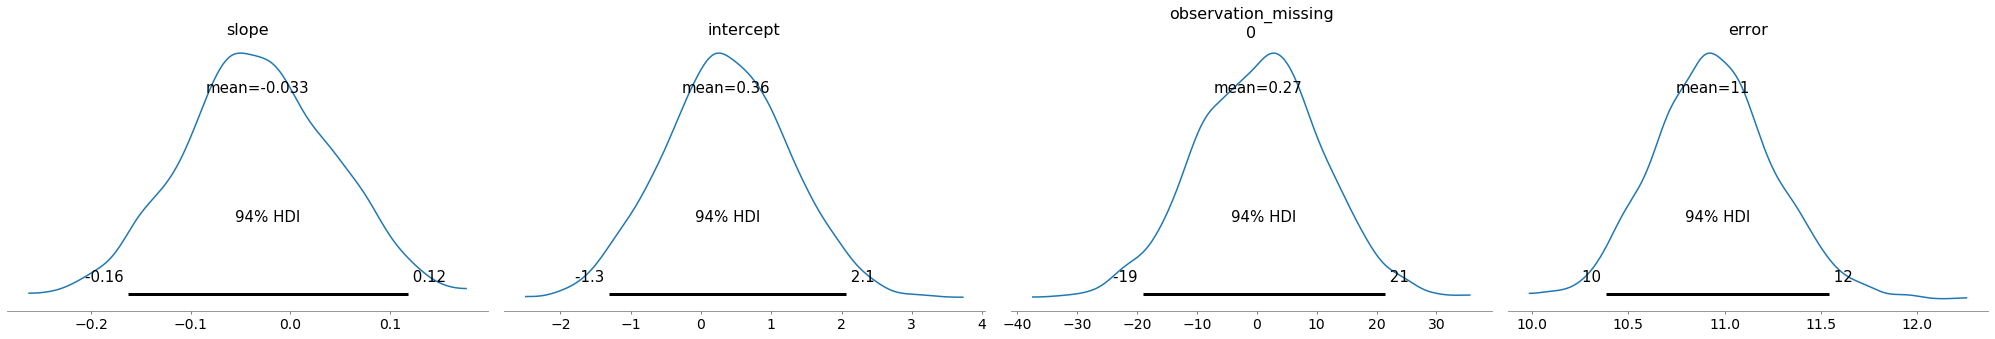

In [84]:
test_df = subset_data(cleaned_df, condition = "PD", phasenum = 4)
x = test_df.num_rep.to_numpy().reshape(-1, 1)
x = x.flatten()
y = test_df.corrected_pitches.to_numpy()

with pm.Model() as model:
    # define priors
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    # predictions
    obs = pm.Normal('observation', a * x + b, s, observed = y)
    
    # use MCMC to sample
    trace = pm.sample(1000, tune=1000, cores=1)
    
pm.plot_posterior(trace)

In [ ]:
group_regressions


In [95]:
a

array([4.18193848])

In [78]:
ln.intercept_

array([0.46341258])

In [81]:
ln.summary_

AttributeError: 'LinearRegression' object has no attribute 'summary_'